# 微调



In [1]:
%matplotlib inline
import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

热狗数据集来源于网络

In [3]:
d2l.DATA_HUB['hotdog']=(d2l.DATA_URL+'hotdog.zip',
                      'fba480ffa8aa7e0febbb511d181409f899b9baa5')
data_dir=d2l.download_extract('hotdog')

train_imgs=torchvision.datasets.ImageFolder(os.path.join(data_dir,'train'))
test_imgs=torchvision.datasets.ImageFolder(os.path.join(data_dir,'test'))
#下载训练集和测试集

图像的大小和纵横比各有不同

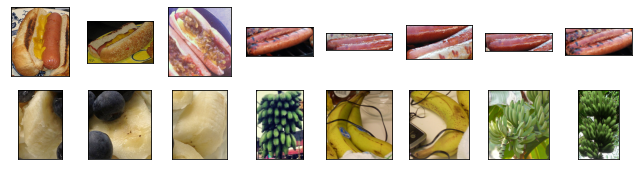

In [4]:
hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i - 1][0] for i in range(8)]
d2l.show_images(hotdogs + not_hotdogs, 2, 8, scale=1.4);

数据增广

In [1]:
normalize=torchvision.transforms.Normalize(
    [0.485,0.456,0.406],[0.229,0.224,0.225])
#规范化
#整理数据
train_augs=torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),#随机剪裁
    torchvision.transforms.RandomHorizontalFlip(),#依概率P=0.5水平翻转
    torchvision.transforms.ToTensor(),
    normalize
])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),#改变大小到256
    torchvision.transforms.CenterCrop(224),#中心裁剪224
    torchvision.transforms.ToTensor(),
    normalize])

NameError: name 'torchvision' is not defined

定义和初始化模型

In [7]:
pretrained_net=torchvision.models.resnet18(pretrained=True)#下载预训练的resnet18
pretrained_net.fc

Linear(in_features=512, out_features=1000, bias=True)

In [8]:
finetune_net=torchvision.models.resnet18(pretrained=True)
finetune_net.fc=nn.Linear(finetune_net.fc.in_features,2)#更改全连接层
nn.init.xavier_uniform_(finetune_net.fc.weight)#xavier初始化全连接层

微调模型

In [9]:
def train_fine_tuning(net,learning_rate,batch_size=127,num_epochs=5,
                     params_group=True):
    train_iter=torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
    os.path.join(data_dir,'train'),transform=train_augs),
                                         batch_size=batch_size,shuffle=True)
    test_iter=torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
    os.path.join(data_dir,'test'),transform=test_augs),
    batch_size=batch_size)
    devices=d2l.try_all_gpus()
    loss=nn.CrossEntropyLoss(reduction="none")#交叉熵损失
    if params_group:
        params_1x=[params for name,params in net.named_parameters()
                  if name not in ["fc.weight","fc.bias"]]
        trainer=torch.optim.SGD([{'params':params_1x},
                                {'params':net.fc.parameters(),
                                'lr':learning_rate*10}],
                               lr=learning_rate,weight_decay=0.001)#全连接层的参数更新扩大10倍
    else:
        trainer=torch.optim.SGD(net.parameters(),lr=learning_rate,
                               weight_decay=0.001)
    d2l.train_ch13(net,train_iter,test_iter,loss,trainer,num_epochs,
                  devices)

使用较小的学习率

loss 0.217, train acc 0.920, test acc 0.924
844.9 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


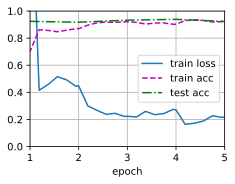

In [10]:
train_fine_tuning(finetune_net,5e-5)#学习率5e-5

为了进行比较，
所有模型参数初始化为随机值

loss 0.389, train acc 0.839, test acc 0.806
1612.5 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


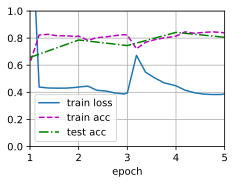

In [11]:
scratch_net = torchvision.models.resnet18()
scratch_net.fc = nn.Linear(scratch_net.fc.in_features, 2)
train_fine_tuning(scratch_net, 5e-4, param_group=False)#不学习参数

In [13]:
for param in finetune_net.parameters():
    param.requires_grad = False

weight = pretrained_net.fc.weight
hotdog_w = torch.split(weight.data, 1, dim=0)[713]
hotdog_w.shape

torch.Size([1, 512])